In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/extracted_buildings.zip' -d '/content/extracted_buildings'

In [ ]:
!unzip '/content/drive/MyDrive/multiclass_segmentation_labels.zip' -d '/content/train_multi/'
!unzip '/content/drive/MyDrive/train/images.zip' -d '/content/train_multi/'

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
# Define the path to the directory
dataset_path = '/content/extracted_buildings'

# Define the batch size
batch_size = 8
img_height = 150
img_width = 150

# Load the dataset and create training and validation sets with a split of 80-20
train_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(150, 150),
    batch_size=batch_size,
    label_mode='categorical'  # Set label_mode to 'categorical'
)

val_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(150, 150),
    batch_size=batch_size,
    label_mode='categorical'  # Set label_mode to 'categorical'
)



# Define the data augmentation layer
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip('horizontal'),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
])

# Configure the dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# Apply data augmentation to the training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


Found 78898 files belonging to 4 classes.
Using 63119 files for training.
Found 78898 files belonging to 4 classes.
Using 15779 files for validation.


In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from keras.models import load_model

def load_data(data_dir, image_size=(150, 150)):
    images = []
    labels = []
    for class_label in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_label)
        if os.path.isdir(class_dir):
            for img_filename in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_filename)
                img = Image.open(img_path).resize(image_size)
                img_array = np.asarray(img)
                images.append(img_array)
                labels.append(int(class_label))
    return np.array(images), np.array(labels)

def create_oversampled_subsets(images, labels, num_subsets, samples_per_class):
    labels = np.array(labels)
    classes, _ = np.unique(labels, return_counts=True)

    shuffled_indices = np.random.permutation(len(labels))
    images = np.array(images)[shuffled_indices]
    labels = labels[shuffled_indices]

    subsets = []

    for i in range(num_subsets):
        model = load_model('/content/building_classifier.h5')
        subset_images = []
        subset_labels = []

        for cls in classes:
            class_indices = np.where(labels == cls)[0]
            if cls == 3:
                selected_indices = np.random.choice(class_indices, samples_per_class, replace=True)
            else:
                selected_indices = np.random.choice(class_indices, samples_per_class, replace=False)
            subset_images.extend(images[selected_indices])
            subset_labels.extend(labels[selected_indices])
        X = np.array(subset_images)
        y = np.array(subset_labels)
        y = tf.keras.utils.to_categorical(y, num_classes=4, dtype='float')
        print(i)
        model.fit(X, y, epochs=20, validation_split=0.1, verbose=2)
        model.save('/content/building_classifier.h5')
# Usage



In [ ]:
images = []
labels = []

images, labels = load_data('/content/extracted_buildings')

<class 'numpy.ndarray'>


In [ ]:
#Import loadmodel from tensor flow
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

num_subsets = 70000
samples_per_class = 1000
incremental_subsets = create_oversampled_subsets(images, labels, num_subsets, samples_per_class)

In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf
from sklearn.metrics import f1_score

# Define a function to calculate the F1 score
def calculate_f1(y_true, y_pred):
    # Convert predictions and true values to binary arrays
    y_pred_binary = tf.round(y_pred)
    y_true_binary = tf.round(y_true)

    # Calculate the F1 score
    score = f1_score(y_true_binary.numpy(), y_pred_binary.numpy(), average='weighted')
    return score

# Load model
model = load_model('/content/building_classifier.h5')

# Evaluate the model on the validation dataset
val_predictions = model.predict(val_ds)
val_labels = np.concatenate([y for x, y in val_ds], axis=0)

# Calculate the F1 score
f1 = calculate_f1(val_labels, val_predictions)
print("F1 Score:", f1)


1973/1973 [==============================] - 12s 6ms/step
F1 Score: 0.8914744035779809


In [ ]:
model.save('/content/drive/MyDrive/Good model/building_classifier_1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import numpy as np
import cv2
for i in range(45):
  path = '/content/extracted_buildings/3/hurricane-florence_hurricane-florence_00000018_post_disaster_destroyed_'+str(9)+'.png'
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (150, 150))

  img = np.expand_dims(img, axis=0)
  print(img.shape)
  prediction = model.predict(img)
  print(np.argmax(prediction))

(1, 150, 150, 3)
1/1 [==============================] - 0s 314ms/step
0
(1, 150, 150, 3)
1/1 [==============================] - 0s 17ms/step
0
(1, 150, 150, 3)
1/1 [==============================] - 0s 17ms/step
0
(1, 150, 150, 3)
1/1 [==============================] - 0s 17ms/step
0
(1, 150, 150, 3)
1/1 [==============================] - 0s 17ms/step
0
(1, 150, 150, 3)
1/1 [==============================] - 0s 16ms/step
0
(1, 150, 150, 3)
1/1 [==============================] - 0s 17ms/step
0
(1, 150, 150, 3)
1/1 [==============================] - 0s 16ms/step
0
(1, 150, 150, 3)
1/1 [==============================] - 0s 16ms/step
0
(1, 150, 150, 3)
1/1 [==============================] - 0s 16ms/step
0
(1, 150, 150, 3)
1/1 [==============================] - 0s 16ms/step
0
(1, 150, 150, 3)
1/1 [==============================] - 0s 17ms/step
0
(1, 150, 150, 3)
1/1 [==============================] - 0s 17ms/step
0
(1, 150, 150, 3)
1/1 [==============================] - 0s 17ms/step
0
(1, 1

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense

model = Sequential([
    # Existing Conv1
    Conv2D(64, (3, 3), strides=(1, 1), padding='valid', activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    # Existing Conv2
    Conv2D(128, (3, 3), strides=(1, 1), padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    # Existing Conv3
    Conv2D(256, (3, 3), strides=(1, 1), padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    # New Conv4
    Conv2D(512, (3, 3), strides=(1, 1), padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    # Flatten the output to feed into the dense layer
    Flatten(),

    # FC: Dense layer with 64 units
    Dense(64, activation='relu'),

    # Output: Dense layer with 4 units for 4 classes
    Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()
model.save('building_classifier.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 148, 148, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 72, 72, 128)       512       
 chNormalization)                                                
                                                        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Compile the model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, Softmax
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Incremental training
for images, labels in incremental_subsets:
    model.load_weights('model_after_subset.h5')
    labels = tf.keras.utils.to_categorical(labels, num_classes=4, dtype='float')
    model.fit(images, labels, epochs=10, validation_split=0.1)

    # Save the model after each subset (optional)
    model.save('model_after_subset.h5')


In [ ]:
model.load_weights('/content/drive/MyDrive/Good model/building_classifier.h5')



labels = tf.keras.utils.to_categorical(labels, num_classes=4, dtype='float')
model.evaluate(val_ds)

658/658 [==============================] - 6s 8ms/step - loss: 0.6597 - accuracy: 0.8899


[0.6597064733505249, 0.8898535966873169]

In [ ]:
from tensorflow.keras.models import Model, load_model
import tensorflow as tf
model = load_model('/content/drive/MyDrive/Good model/building_classifier.h5')
for images, labels in incremental_subsets:

    labels = tf.keras.utils.to_categorical(labels, num_classes=4, dtype='float')
    A = model.predict(images)
    break
print(A)

125/125 [==============================] - 57s 455ms/step
[[9.99999940e-01 8.06131961e-09 9.29136455e-12 2.13908041e-11]
 [9.54981923e-01 2.59111393e-02 1.87058952e-02 4.01109486e-04]
 [1.01112004e-04 9.99898851e-01 1.18558949e-08 5.57005180e-13]
 ...
 [9.91253746e-09 8.10350139e-06 6.31133844e-06 9.99985516e-01]
 [5.18408997e-05 1.72392962e-08 1.87499580e-07 9.99947846e-01]
 [6.03303907e-10 3.10407842e-07 1.96354407e-07 9.99999464e-01]]


In [ ]:
B = []
class_labels = ["no-damage", "minor damage", "major damage", "destroyed"]
for i in A:
  B.append(class_labels[np.argmax(i)])

In [ ]:
B = np.array(B)
print(np.unique(B, return_counts=True))

(array(['destroyed', 'major damage', 'minor damage', 'no-damage'],
      dtype='<U12'), array([1008, 1248, 1064,  680]))


In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


Physical devices cannot be modified after being initialized


In [ ]:
# Assuming you have your train_ds and val_ds ready
# and the model is defined as 'model'

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks (optional)
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'model_best_checkpoint.h5', save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
]

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,  # You can adjust the number of epochs
    callbacks=callbacks
)

# After training, you can evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation loss: {val_loss}")
print(f"Validation accuracy: {val_accuracy}")


### Transfer Learning

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, concatenate

def conv_block(input_tensor, num_filters):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters=num_filters, kernel_size=(3, 3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters=num_filters, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

def build_unet(input_shape, num_classes=4):
    """Function to build a U-Net using the Keras functional API for multi-class segmentation"""
    inputs = Input(input_shape)

    # Contracting Path
    c1 = conv_block(inputs, 32)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 64)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 128)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 256)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = conv_block(p4, 512)

    # Expansive Path
    u6 = Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = conv_block(u6, 256)

    u7 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = conv_block(u7, 128)

    u8 = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = conv_block(u8, 64)

    u9 = Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = conv_block(u9, 32)

    # Output Layer for 4-class segmentation
    output = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[output])
    return model

# Create a new U-Net model for 4-class segmentation
input_shape = (1024, 1024, 3)
model = build_unet(input_shape)
model.summary()


In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, Softmax
from tensorflow.keras.optimizers import Adam

pretrained_model_path = '/content/drive/MyDrive/Good model/building_localizer.h5'
base_model = load_model(pretrained_model_path)


last_conv_layer = base_model.layers[-2].output

output_layer = Conv2D(5, (1, 1), activation=None, name='output_conv')(last_conv_layer)



model = Model(inputs=base_model.input, outputs=output_layer)

for layer in base_model.layers[:-2]:
    layer.trainable = False

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


model.save('/content/modified_unet_for_4class_segmentation.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


Physical devices cannot be modified after being initialized


In [ ]:
from tensorflow.keras.utils import Sequence
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tifffile
import cv2
class SegmentationDataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, image_filenames, image_dir, mask_dir, batch_size=32, image_size=(572, 572), shuffle=True):
        'Initialization'
        self.image_filenames = np.array(image_filenames)
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        batch_image_filenames = self.image_filenames[indexes]

        # Generate data
        X, y = self.__data_generation(batch_image_filenames)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_filenames))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_image_filenames):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((len(batch_image_filenames), *self.image_size, 3))
        y = np.empty((len(batch_image_filenames), *self.image_size, 1))

        # Generate data
        for i, img_name in enumerate(batch_image_filenames):
            # Store sample
            img_path = os.path.join(self.image_dir, img_name)
            mask_path = os.path.join(self.mask_dir, img_name)

            img = tifffile.imread(img_path)
            img = img_to_array(img) / 255.0
            X[i,] = img

            # Store class
            mask = cv2.imread(mask_path[:-4] + ".png", cv2.IMREAD_GRAYSCALE)
            y[i,] = mask[:, :, np.newaxis]

        return X, y

3


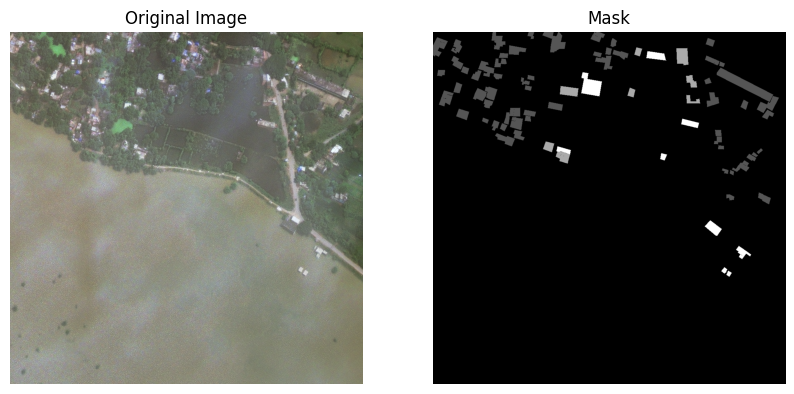

In [ ]:
import matplotlib.pyplot as plt
import os
import tifffile
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
import cv2
def load_image_and_mask(image_filename, image_dir, mask_dir):
    img_path = os.path.join(image_dir, image_filename)
    mask_path = os.path.join(mask_dir, image_filename)

    img = tifffile.imread(img_path)
    img = img_to_array(img) / 255.0

    # Assuming mask is saved as a .npy file
    mask = cv2.imread(mask_path[:-4] + ".png", cv2.IMREAD_GRAYSCALE)

    print(mask.max())
    return img, mask  # Assuming mask is single-channel

def plot_image_and_mask(img, mask):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('Mask')
    ax[1].axis('off')

    plt.show()

# Example usage
image_filename = 'nepal-flooding_00000425_post_disaster.tif'
image_dir = '/content/train_multi/images'
mask_dir = '/content/train_multi/masks'

img, mask = load_image_and_mask(image_filename, image_dir, mask_dir)
plot_image_and_mask(img, mask)


In [ ]:
# Load the modified U-Net model for 4-class segmentation
import tensorflow as tf
from keras.preprocessing import image_dataset_from_directory
from keras.utils import image_dataset_from_directory
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

model = load_model('/content/modified_unet_for_4class_segmentation.h5')


model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

train_image_dir = '/content/train_multi/images'
train_mask_dir = '/content/train_multi/masks'


batch_size = 4
image_size = (1024, 1024)
validation_split = 0.15

# Get all filenames and split into training and validation
all_filenames = np.array(os.listdir(train_image_dir))
np.random.shuffle(all_filenames)
split_index = int(len(all_filenames) * (1 - validation_split))
train_filenames, val_filenames = all_filenames[:split_index], all_filenames[split_index:]

# Create data generators for training and validation
train_gen = SegmentationDataGenerator(train_filenames, train_image_dir, train_mask_dir, batch_size=batch_size, image_size=image_size)
val_gen = SegmentationDataGenerator(val_filenames, train_image_dir, train_mask_dir, batch_size=batch_size, image_size=image_size)

checkpoint = ModelCheckpoint('/content/drive/MyDrive/model_checkpoint.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True)

# Train the model
history = model.fit(
    train_gen,
    epochs=25,
    validation_data=val_gen,
    callbacks=[checkpoint, earlystopping]
)

# Save the final model
model.save('/content/final_model.h5')

Epoch 1/25
327/327 [==============================] - ETA: 0s - loss: 0.3106 - accuracy: 0.9535
Epoch 1: val_accuracy improved from -inf to 0.98216, saving model to /content/drive/MyDrive/model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


327/327 [==============================] - 81s 207ms/step - loss: 0.3106 - accuracy: 0.9535 - val_loss: 0.1625 - val_accuracy: 0.9822
Epoch 2/25
327/327 [==============================] - ETA: 0s - loss: 0.1645 - accuracy: 0.9826
Epoch 2: val_accuracy did not improve from 0.98216
327/327 [==============================] - 61s 188ms/step - loss: 0.1645 - accuracy: 0.9826 - val_loss: 0.1385 - val_accuracy: 0.9812
Epoch 3/25
327/327 [==============================] - ETA: 0s - loss: 0.1550 - accuracy: 0.9815
Epoch 3: val_accuracy did not improve from 0.98216
327/327 [==============================] - 61s 187ms/step - loss: 0.1550 - accuracy: 0.9815 - val_loss: 0.1327 - val_accuracy: 0.9805
Epoch 4/25
327/327 [==============================] - ETA: 0s - loss: 0.1523 - accuracy: 0.9808
Epoch 4: val_accuracy did not improve from 0.98216
327/327 [==============================] - 61s 187ms/step - loss: 0.1523 - accuracy: 0.9808 - val_loss: 0.1303 - val_accuracy: 0.9801
Epoch 5/25
327/327 [===

In [ ]:
x = model.predict(val_gen)

58/58 [==============================] - 9s 150ms/step


1/1 [==============================] - 0s 47ms/step


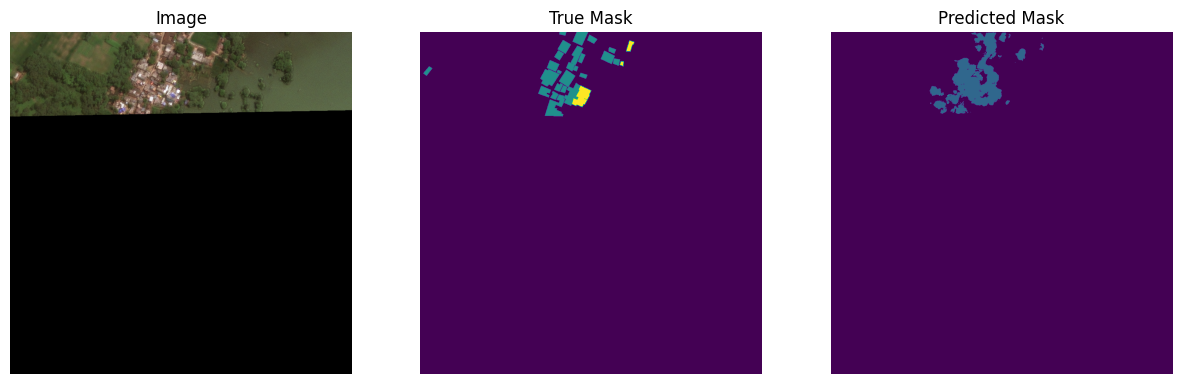

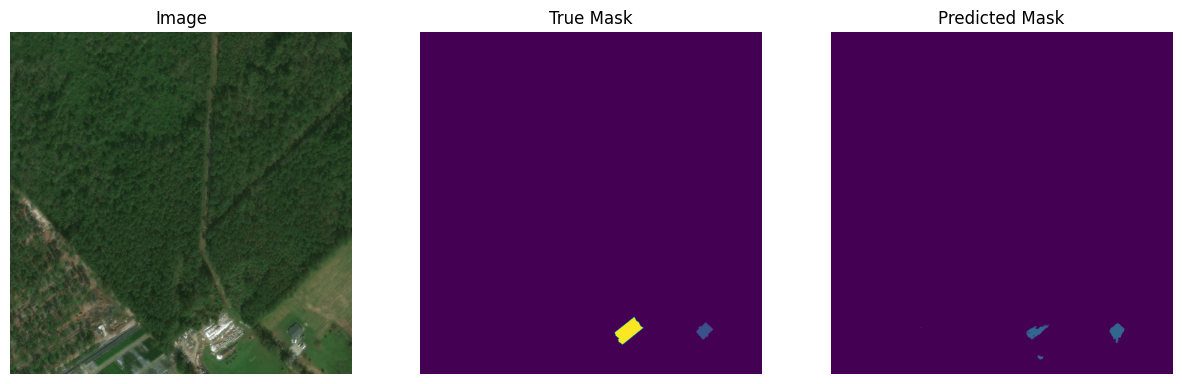

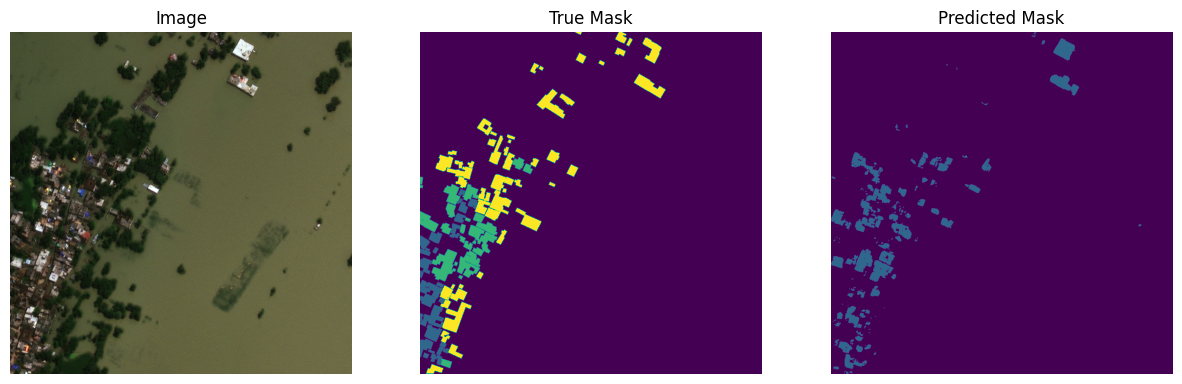

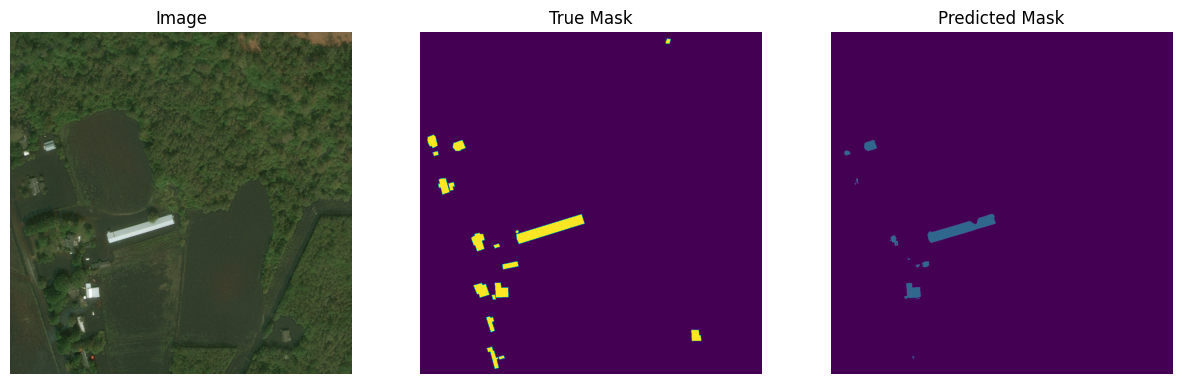

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images, true masks, and predicted masks
def display(display_list, title_list):
    plt.figure(figsize=(15, 5))

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title_list[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()


for images, true_masks in val_gen:
    # Predict masks
    pred_masks = model.predict(images)
    pred_masks = np.argmax(pred_masks, axis=-1)


    for i in range(4):  #
        display([images[i], true_masks[i, :, :, 0], pred_masks[i]], ["Image", "True Mask", "Predicted Mask"])

    break  # Only take the first batch
